### Check if configuration has been run already and change directory to repository root:

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import pandas as pd
import u19_pipeline.automatic_job.recording_handler as rec_handler
import u19_pipeline.automatic_job.recording_process_handler as rec_process_handler

from u19_pipeline import recording, recording_process

import u19_pipeline.ephys_pipeline as ephys_pipeline
from u19_pipeline.ephys_pipeline import  ephys_element

import u19_pipeline.imaging_pipeline as imaging_pipeline
from u19_pipeline.imaging_pipeline import  imaging_element, scan_element


Connecting alvaros@datajoint00.pni.princeton.edu:3306


### Run recording main pipeline

In [16]:
l = rec_handler.RecordingHandler.pipeline_handler_main()

function to apply: local_transfer_check
psutil.Process(pid=6785, name='python3.7', status='running', started='11:21:52')
[]
is_finished False status_update 0


### Run recording_prcoess main pipeline

In [18]:
l = rec_process_handler.RecProcessHandler.pipeline_handler_main()

   recording_id  job_id recording_modality  status_processing_id  \
0            55     107  electrophysiology                     6   

   fragment_number                         recording_process_pre_path  \
0                0  sbolkan/sbolkan_a2a_492/20220624/TowersTask_g0...   

                         recording_process_post_path  \
0  sbolkan/sbolkan_a2a_492/20220624/TowersTask_g0...   

                       task_copy_id_pre                     task_copy_id_post  \
0  ba0ce54c-f3d9-11ec-b3c1-15403b7b75ed  87f3e824-f499-11ec-835c-cd84b862b754   

  slurm_id  
0  8779643  


Clustering:   0%|          | 0/1 [00:00<?, ?it/s]


Exception HERE ................
update_dict {'value_update': None, 'error_info': {'error_message': "No valid full-path found (from [PosixPath('/Volumes/braininit/Data/Raw/electrophysiology')]) for sbolkan/sbolkan_a2a_492/20220624/TowersTask_g0/TowersTask_g0_imec0/job_id_107/kilosort_output", 'error_exception': 'Traceback (most recent call last):\n  File "/Users/alvaros/Documents/MATLAB/BrainCogsProjects/Datajoint_proj/U19-pipeline_python/u19_pipeline/automatic_job/recording_handler.py", line 22, in inner_function\n    argout = func(*args, **kwargs)\n  File "/Users/alvaros/Documents/MATLAB/BrainCogsProjects/Datajoint_proj/U19-pipeline_python/u19_pipeline/automatic_job/recording_process_handler.py", line 322, in populate_element\n    ep.populate_element_data(rec_series[\'job_id\'])\n  File "/Users/alvaros/Documents/MATLAB/BrainCogsProjects/Datajoint_proj/U19-pipeline_python/u19_pipeline/automatic_job/ephys_element_populate.py", line 63, in populate_element_data\n    ephys_element.Cluster

In [12]:
import u19_pipeline.utils.scp_transfers as scp_tr


scp_tr.transfer_scp(host='128.112.222.130', username='ephys', remote_path='D:/Data/Scott/d1_231/20220624/TowersTask_g0', local_path='/Volumes/braininit/Data/Raw/electrophysiology/sbolkan/sbolkan_d1_231/20220624/TowersTask_g0')


128.112.222.130
ephys
/Users/alvaros/.ssh/id_rsa_copyfiles
D:/Data/Scott/d1_231/20220624/TowersTask_g0
/Volumes/braininit/Data/Raw/electrophysiology/sbolkan/sbolkan_d1_231/20220624/TowersTask_g0
Found SSH key at self /Users/alvaros/.ssh/id_rsa_copyfiles


SCPException: scp: D:/Data/Scott/d1_231/20220624/TowersTask_g0: No such file or directory

### Insert cat_gt params 1 & 2

In [3]:
cat_gt_params =  {
      "apfilter": ["biquad",2,300,0],
      "gfix": [0.40,0.10,0.02],
      "extras": ["prb_fld", "t_miss_ok", "ap", "gblcar", "out_prb_fld"],
      "lazy": True
   }
 
ephys_element.PreClusterParamSet.insert_new_params(
    precluster_method='catgt',
    paramset_idx=2,
    params=cat_gt_params,
    paramset_desc='Spike sorting using Kilosort w lazy')


cat_gt_params =  {
      "apfilter": ["biquad",2,301,0],
      "gfix": [0.40,0.10,0.02],
      "extras": ["prb_fld", "t_miss_ok", "ap", "gblcar", "out_prb_fld"],
      "lazy": True
   }
 
ephys_element.PreClusterParamSet.insert_new_params(
    precluster_method='catgt2',
    paramset_idx=3,
    params=cat_gt_params,
    paramset_desc='Spike sorting using Kilosort w lazy')


ephys_element.PreClusterParamSet()
 


paramset_idx,precluster_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,catgt,Catgt base params,4271fe75-1732-5821-0070-45b4c286e867,=BLOB=
1,catgt2,Catgt test params,3d1047b9-deec-bc7f-d5a5-4e30c1665f07,=BLOB=
2,catgt,Catgt base params w lazy,724eb89a-e0ac-00b9-db32-0b93822caf7b,=BLOB=
3,catgt2,Catgt test params w lazy,ac733d65-f3cc-1c60-e464-1adcbc4887ec,=BLOB=


### Insert precluster_param_lists

In [5]:
paramlist = {'precluster_param_steps_id':0}
ephys_element.PreClusterParamSteps.insert1(paramlist, skip_duplicates=True)

paramorder = {
'precluster_param_steps_id': 0,
'step_number': 1,
'paramset_idx': 0
}
ephys_element.PreClusterParamSteps.Step.insert1(paramorder, skip_duplicates=True)


paramlist = {'precluster_param_steps_id':1}
ephys_element.PreClusterParamSteps.insert1(paramlist, skip_duplicates=True)

paramorder = {
'precluster_param_steps_id': 1,
'step_number': 1,
'paramset_idx': 1
}
ephys_element.PreClusterParamSteps.Step.insert1(paramorder, skip_duplicates=True)


paramlist = {'precluster_param_steps_id':2}
ephys_element.PreClusterParamSteps.insert1(paramlist,skip_duplicates=True)

paramorder = {
'precluster_param_steps_id': 2,
'step_number': 1,
'paramset_idx': 0
}
ephys_element.PreClusterParamSteps.Step.insert1(paramorder, skip_duplicates=True)
paramorder = {
'precluster_param_steps_id': 2,
'step_number': 2,
'paramset_idx': 1
}
ephys_element.PreClusterParamSteps.Step.insert1(paramorder, skip_duplicates=True)

ephys_element.PreClusterParamSteps.Step()


precluster_param_steps_id,step_number Order of operations,paramset_idx
0,1,0
2,1,0
1,1,1
2,2,1


### Insert cluster_paramsets

In [16]:
params = {
 "fs": 30000,
 "fshigh": 150,
 "minfr_goodchannels": 0.1,
 "Th": [10, 4],
 "lam": 10,
 "AUCsplit": 0.9,
 "minFR": 0.02,
 "momentum": [20, 400],
 "sigmaMask": 30,
 "ThPre": 8,
 "CAR": 1, 
 "spkTh": -6,
 "reorder": 1,
 "nskip": 25,
 "GPU": 1,
 "Nfilt": 1024,
 "nfilt_factor": 4,
 "ntbuff": 64,
 "NT": 32832,
 "whiteningRange": 32,
 "nSkipCov": 25,
 "scaleproc": 200,
 "nPCs": 3,
 "useRAM": 0,
 "trange": [0, 1000000000],
"NchanTOT": 384
}

ephys_element.ClusteringParamSet.insert_new_params(
    processing_method='kilosort2',
    paramset_idx=0,
    params=params,
    paramset_desc='Spike sorting using Kilosort2')


params = {
 "fs": 30000,
 "fshigh": 150,
 "minfr_goodchannels": 0.1,
 "Th": [10, 4],
 "lam": 10,
 "AUCsplit": 0.9,
 "minFR": 0.02,
 "momentum": [20, 400],
 "sigmaMask": 30,
 "ThPre": 8,
 "CAR": 1, 
 "spkTh": -6,
 "reorder": 1,
 "nskip": 25,
 "GPU": 2,
 "Nfilt": 1024,
 "nfilt_factor": 4,
 "ntbuff": 64,
 "NT": 32832,
 "whiteningRange": 32,
 "nSkipCov": 25,
 "scaleproc": 200,
 "nPCs": 3,
 "useRAM": 0,
 "trange": [0, 1000000000],
"NchanTOT": 384
}

ephys_element.ClusteringParamSet.insert_new_params(
    processing_method='kilosort2',
    paramset_idx=1,
    params=params,
    paramset_desc='Spike sorting using Kilosort2')


paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,b9e07e55-95ea-3463-a740-90291de41da6,=BLOB=
1,kilosort2,Spike sorting using Kilosort2,697d24ac-2d46-a6e8-6f6b-2d1afaea000d,=BLOB=
2,kilosort,Spike sorting using Kilosort2,e6bfd993-55fc-5844-bdfe-30fab9888f28,=BLOB=


### Insert Manuel config params for Kilosort 3

In [17]:

ops = dict()
# sample rate
ops['fs'] = 30000;  
ops['fshigh'] = 300;   

# minimum firing rate on a "good" channel (0 to skip)
ops['minfr_goodchannels'] = 0; 

# threshold on projections (like in Kilosort1, can be different for last pass like [10 4])
ops['Th'] = [10, 4];  

# how important is the amplitude penalty (like in Kilosort1, 0 means not used, 10 is average, 50 is a lot) 
ops['lam'] = 10;  

# splitting a cluster at the end requires at least this much isolation for each sub-cluster (max = 1)
ops['AUCsplit'] = 0.9; 

# minimum spike rate (Hz), if a cluster falls below this for too long it gets removed
ops['minFR'] = 1/50; 

# number of samples to average over (annealed from first to second value) 
ops['momentum'] = [20, 400]; 

# spatial constant in um for computing residual variance of spike
ops['sigmaMask'] = 30; 

# threshold crossings for pre-clustering (in PCA projection space)
ops['ThPre'] = 8; 
ops['reorder']         = 1;       # whether to reorder batches for drift correction. 
ops['nskip']           = 25;      # how many batches to skip for determining spike PCs

# danger, changing these settings can lead to fatal errors
# options for determining PCs
ops['spkTh']           = -6;      # spike threshold in standard deviations (-6)

ops['GPU']                 = 1; # has to be 1, no CPU version yet, sorry
# ops.Nfilt               = 1024; # max number of clusters
ops['nfilt_factor']        = 4; # max number of clusters per good channel (even temporary ones)
ops['ntbuff']              = 64;    # samples of symmetrical buffer for whitening and spike detection
ops['NT']                  = 64*1024+ ops['ntbuff']; # must be multiple of 32 + ntbuff. This is the batch size (try decreasing if out of memory). 
ops['whiteningRange']      = 32; # number of channels to use for whitening each channel
ops['nSkipCov']            = 25; # compute whitening matrix from every N-th batch
ops['scaleproc']           = 200;   # int16 scaling of whitened data
ops['nPCs']                = 3; # how many PCs to project the spikes into
ops['useRAM']              = 0; # not yet available


ops['trange']              = [0, 100000000000000]
ops['NchanTOT']            = 384
ops['sig']                 = 20;  #spatial smoothness constant for registration
ops['nblocks']             = 5; # blocks for registration. 0 turns it off, 1 does rigid registration. Replaces "datashift" option. 

ephys_element.ClusteringParamSet.insert_new_params(
    processing_method='kilosort',
    paramset_idx=2,
    params=ops,
    paramset_desc='Spike sorting using Kilosort2')


ephys_element.ClusteringParamSet()

/Users/alvaros/opt/anaconda3/envs/u19_datajoint/lib/python3.7/site-packages/datajoint/connection.py:304: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,b9e07e55-95ea-3463-a740-90291de41da6,=BLOB=
1,kilosort2,Spike sorting using Kilosort2,697d24ac-2d46-a6e8-6f6b-2d1afaea000d,=BLOB=
2,kilosort,Spike sorting using Kilosort2,e6bfd993-55fc-5844-bdfe-30fab9888f28,=BLOB=


### Insert defaultParmas table for some recordings

In [14]:

# For recording 39, all probes equal, list = 0
default_params_key = dict()
default_params_key['recording_id'] = 39
default_params_key['fragment_number'] = 0
default_params_key['preprocess_param_steps_id'] = 0
default_params_key['paramset_idx'] = 0


recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

# For recording 41, all probes equal, list = 2   (list 2 has two different preparams catgt & catgt2)
default_params_key = dict()
default_params_key['recording_id'] = 41
default_params_key['fragment_number'] = 0
default_params_key['preprocess_param_steps_id'] = 2
default_params_key['paramset_idx'] = 0


recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

# For recording 40, all probes different params
default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 0
default_params_key['preprocess_param_steps_id'] = 0
default_params_key['paramset_idx'] = 0
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 1
default_params_key['preprocess_param_steps_id'] = 0
default_params_key['paramset_idx'] = 1
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 2
default_params_key['preprocess_param_steps_id'] = 1
default_params_key['paramset_idx'] = 0
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0

recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

default_params_key = dict()
default_params_key['recording_id'] = 40
default_params_key['fragment_number'] = 3
default_params_key['preprocess_param_steps_id'] = 1
default_params_key['paramset_idx'] = 1
default_params_key['default_same_preparams_all'] = 0
default_params_key['default_same_params_all'] = 0


recording.DefaultParams.insert1(default_params_key, skip_duplicates=True)

recording.DefaultParams()


recording_id Unique number assigned to recording,fragment_number probe/field_of_view # if not always the same,default_same_preparams_all by default all probes/fields of view have same preparameters,pre_param_list_id preparams index for recording (could be imaging/ephys),default_same_params_all by default all probes/fields of view have same parameters,paramset_idx params index for recording (could be imaging/ephys)
37,0,1,0,1,0
39,0,1,0,1,0
40,0,0,0,0,0
40,1,0,0,0,1
40,2,0,1,0,0
40,3,0,1,0,1
41,0,1,2,1,0


## "Simplified" Ephys diagram and Imaging diagram

In [3]:
ephys_pipeline = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')
ephys_element = dj.create_virtual_module('ephys_element', 'u19_pipeline_ephys_element')
probe_element = dj.create_virtual_module('probe_element', 'u19_pipeline_probe_element')


imaging_pipeline = dj.create_virtual_module('imaging_pipeline', 'u19_imaging_pipeline')
scan_element = dj.create_virtual_module('scan_element', 'u19_pipeline_scan_element')
imaging_element = dj.create_virtual_module('imaging_element', 'u19_pipeline_imaging_element')


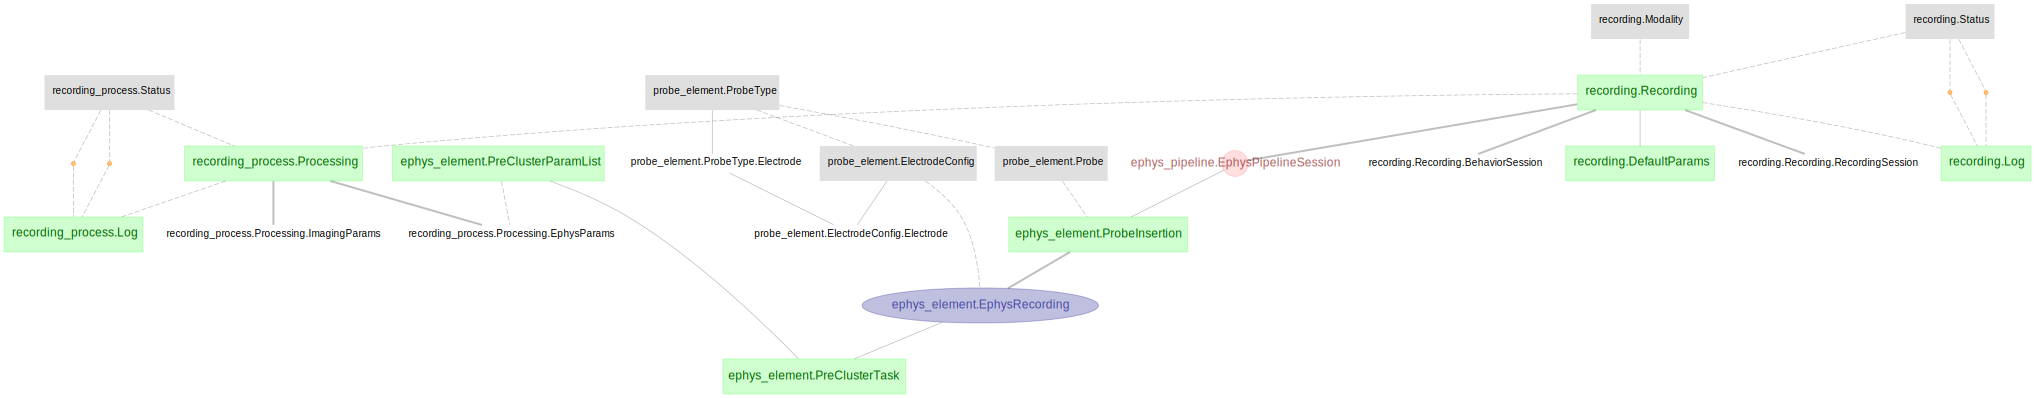

In [5]:
dj.ERD(recording) + dj.ERD(recording_process) + dj.ERD(ephys_pipeline)  + dj.ERD(ephys_element.EphysRecording) + dj.ERD(ephys_element.PreClusterTask) + dj.ERD(ephys_element.PreClusterParamList)


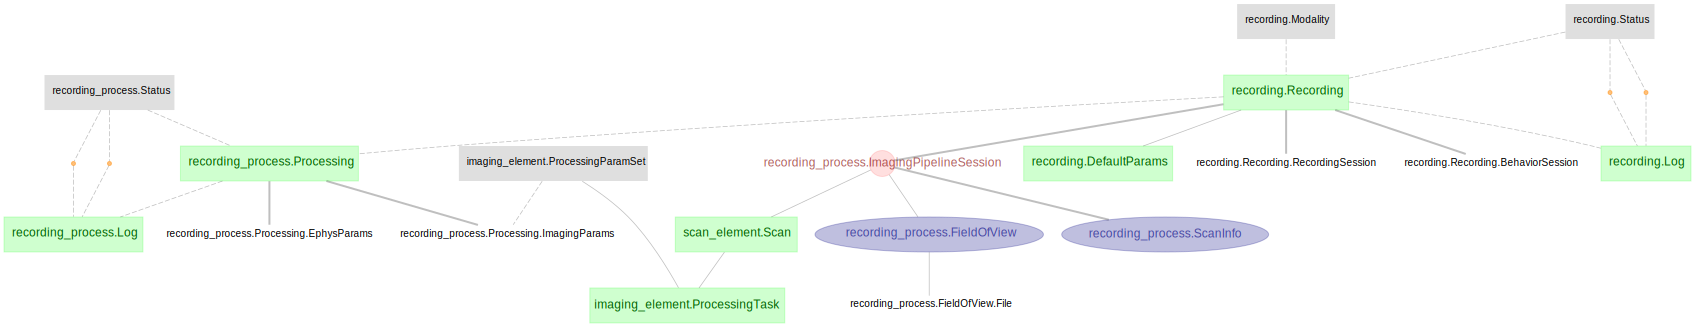

In [6]:
dj.ERD(recording) + dj.ERD(recording_process) + dj.ERD(imaging_pipeline) + dj.ERD(scan_element.Scan) + dj.ERD(imaging_element.ProcessingTask) + dj.ERD(imaging_element.ProcessingParamSet)


# DANGER, delete EphysPipeline tables

In [6]:
ephys_pipeline_db = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')
ephys_pipeline_db.EphysPipelineSession.delete()

,job_id,recording_id,status_processing_id,fragment_number,recording_process_pre_path,recording_process_post_path,task_copy_id_pre,task_copy_id_post,slurm_id
0,56,39,-1,0,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,b5073818-daad-4a46-af50-6ec1519de31f,None,None
1,57,39,-1,1,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,None,None,None
2,58,39,-1,2,ms81/ms81_M011/20211116/TowersTask_g0/TowersTa...,None,None,None,None
3,59,40,-1,0,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
4,60,40,-1,1,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
5,61,40,-1,2,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
6,62,40,-1,3,ms81/ms81_M011/20211120/TowersTask_g0/TowersTa...,None,None,None,None
7,63,41,-1,0,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None
8,64,41,-1,1,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None
9,65,41,-1,2,ms81/ms81_M012/20211210/2021-12-10_g0/2021-12-...,None,None,None,None


In [13]:
import copy

# Get cluster param sets
rec_process_keys = {'job_id': 85}


params_df = pd.DataFrame((ephys_pipeline.ephys_element.ClusteringParamSet.proj('params', 'clustering_method') * \
recording_process.Processing.EphysParams.proj('paramset_idx') \
& rec_process_keys).fetch(as_dict=True))
params_df = params_df.drop('paramset_idx', axis=1)

real_params = params_df.loc[0, 'params']
real_params['clustering_method'] = params_df.loc[0, 'clustering_method']



{'fs': 30000,
 'fshigh': 150,
 'minfr_goodchannels': 0.1,
 'Th': [10, 4],
 'lam': 10,
 'AUCsplit': 0.9,
 'minFR': 0.02,
 'momentum': [20, 400],
 'sigmaMask': 30,
 'ThPre': 8,
 'CAR': 1,
 'spkTh': -6,
 'reorder': 1,
 'nskip': 25,
 'GPU': 1,
 'Nfilt': 1024,
 'nfilt_factor': 4,
 'ntbuff': 64,
 'NT': 32832,
 'whiteningRange': 32,
 'nSkipCov': 25,
 'scaleproc': 200,
 'nPCs': 3,
 'useRAM': 0,
 'trange': [0, 1000000000],
 'NchanTOT': 384,
 'clustering_method': 'kilosort2'}

In [37]:
from u19_pipeline import utility
from scipy.io import savemat
import numpy as np

key = {'job_id': 63}

recording_key = (recording_process.Processing.proj('recording_id', insertion_number='fragment_number') & key).fetch1()
del recording_key["job_id"]

print(recording_key)

probe_key = (ephys_element.ProbeInsertion & recording_key).fetch('probe', as_dict=True)
probe_type_key = (probe_element.Probe & probe_key).fetch('probe_type', as_dict=True) 


chanmap_df = pd.DataFrame((probe_element.ElectrodeConfig * probe_element.ElectrodeConfig.Electrode * probe_element.ProbeType.Electrode & probe_type_key).fetch(as_dict=True))

new_shape = (chanmap_df['electrode'].shape[0], 1)

mat_file_dict = dict()
mat_file_dict['xcoords'] = chanmap_df['x_coord'].values.reshape(new_shape)
mat_file_dict['ycoords'] = chanmap_df['y_coord'].values.reshape(new_shape)
mat_file_dict['chanMap0ind'] = chanmap_df['electrode'].astype('float64').values.reshape(new_shape)
mat_file_dict['chanMap'] = chanmap_df['electrode'].astype('float64').values.reshape(new_shape) + 1
mat_file_dict['connected'] = np.ones(new_shape).astype('bool')
mat_file_dict['shankInd'] = chanmap_df['shank'].astype('float64').values.reshape(new_shape)
mat_file_dict['name'] = chanmap_df.loc[0, 'probe_type']


savemat('chanmap_test_np2.mat',mat_file_dict)

chanmap_df


{'recording_id': 41, 'insertion_number': 0}


,electrode_config_hash,probe_type,electrode,electrode_config_name,shank,shank_col,shank_row,x_coord,y_coord
0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,0-383,0,0,0,16.0,0.0
1,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,1,0-383,0,1,0,48.0,0.0
2,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,0-383,0,0,1,0.0,20.0
3,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,3,0-383,0,1,1,32.0,20.0
4,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,0-383,0,0,2,16.0,40.0
...,...,...,...,...,...,...,...,...,...
379,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,379,0-383,0,1,189,32.0,3780.0
380,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,380,0-383,0,0,190,16.0,3800.0
381,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,381,0-383,0,1,190,48.0,3800.0
382,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,382,0-383,0,0,191,0.0,3820.0


In [14]:
ycoords, xcoords, shankInd, name, connected, chanMap0ind, chanMap

""


In [15]:
ephys_element.ProbeInsertion() 

recording_id Unique number assigned to recording,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
37,1,19108323152
39,2,19108323241
40,3,19108323241
36,0,19108323362
36,1,19108323562
37,0,19108323562
39,0,19108323621
40,0,19108323621
41,0,19108323621
40,2,19122511462


In [5]:
import json
su = " {'catgt': {'apfilter': ['biquad', 2, 300, 0], 'gfix': [0.4, 0.1, 0.02], 'extras': ['prb_fld', 't_miss_ok', 'ap', 'gblcar', 'out_prb_fld']}}"

su = su.replace("'", '"')

sa = json.loads(su)

if "catgt" in sa:
    print('si cat gt')
else:
    print('no catgt')


si cat gt


In [6]:
sa

{'catgt': {'apfilter': ['biquad', 2, 300, 0],
  'gfix': [0.4, 0.1, 0.02],
  'extras': ['prb_fld', 't_miss_ok', 'ap', 'gblcar', 'out_prb_fld']}}

In [23]:
rec_process_keys = [
    {'job_id': 84},
    {'job_id': 85},
]

params_df = pd.DataFrame((ephys_element.ClusteringParamSet.proj('params', 'clustering_method') * \
recording_process.Processing.EphysParams.proj('paramset_idx') \
& rec_process_keys).fetch(as_dict=True))
params_df = params_df.drop('paramset_idx', axis=1)

params_df

#Insert clustering method in params itself (for BrainCogsEphysSorters)
#real_params = params_df.loc[0, 'params']
#real_params['clustering_method'] = params_df.loc[0, 'clustering_method']

params_df

,job_id,clustering_method,params
0,84,kilosort,"{'fs': 30000, 'fshigh': 300, 'minfr_goodchanne..."
1,85,kilosort,"{'fs': 30000, 'fshigh': 300, 'minfr_goodchanne..."


In [24]:
params_df['params'] = params_df.apply(lambda x: {**x['params'], **{'clustering_method':x['clustering_method']}},axis=1)

In [26]:
s = params_df.loc[1, 'params']
s

{'fs': 30000,
 'fshigh': 300,
 'minfr_goodchannels': 0,
 'Th': [10, 4],
 'lam': 10,
 'AUCsplit': 0.9,
 'minFR': 0.02,
 'momentum': [20, 400],
 'sigmaMask': 30,
 'ThPre': 8,
 'reorder': 1,
 'nskip': 25,
 'spkTh': -6,
 'GPU': 1,
 'nfilt_factor': 4,
 'ntbuff': 64,
 'NT': 65600,
 'whiteningRange': 32,
 'nSkipCov': 25,
 'scaleproc': 200,
 'nPCs': 3,
 'useRAM': 0,
 'trange': [0, 100000000000000],
 'NchanTOT': 384,
 'sig': 20,
 'nblocks': 5,
 'clustering_method': 'kilosort'}